# 学习如何使用 MS COCO 数据集   
微软发布的 MS COCO 数据集是一个大型图像数据集, 专为目标检测、人体关键点检测、语义分割和字幕生成而设计。本文尝试学习python如何使用该数据集（主要关注目标检测）。

## COCO 数据格式
coco 数据集的标注数据采用json格式存储，基本结构如下：

In [ ]:
{
    "info": info,
    "images": [image], #这是一个image的列表，如[image1,image2,....]，
    "annotations": [annotation], #同理
    "licenses": [license], #同理
    "categories": [category]
}

info{
    "year": int, 
    "version": str, 
    "description": str, 
    "contributor": str, 
    "url": str, 
    "date_created": datetime,
}

image{
    "id": int, 
    "width": int, 
    "height": int, 
    "file_name": str, 
    "license": int, 
    "flickr_url": str, 
    "coco_url": str, 
    "date_captured": datetime,
}

license{
    "id": int, 
    "name": str, 
    "url": str,
}


# 目标检测的annotation
annotation{
    "id": int, 
    "image_id": int, 
    "category_id": int, 
    "segmentation": RLE or [polygon], 
    "area": float, 
    "bbox": [x,y,width,height], 
    "iscrowd": 0 or 1,
}

categories[{
    "id": int, 
    "name": str, 
    "supercategory": str,
}]

## COCO API

#### 安装coco api
COCO数据集提供了用于加载、解析和可视化的API，本文主要探索python api

In [ ]:
git clone https://github.com/cocodataset/cocoapi.git   # git、cd等shell命令在jupyter notebook中运行需要在前面加！
cd cocoapi/PythonAPI
make -j4 install # 这里使用install参数指示将pycocotools安装到conda虚拟环境中的site-packages 
cd ..


#### 数据集准备
1. 下载图像数据集（train2017.zip,val2017.zip,test2017.zip）并解压到cocoapi/images文件夹下
2. 下载标签数据集（）并解压到cocoapi/annotations文件夹下

In [ ]:
#下载图像数据

mkdir images
cd images

wget -c http://images.cocodataset.org/zips/train2017.zip  # --continue, 断点续传
wget -c http://images.cocodataset.org/zips/val2017.zip
wget -c http://images.cocodataset.org/zips/test2017.zip

unzip train2017.zip  
unzip val2017.zip
unzip test2017.zip

#下载标签数据

cd ..
makdir annotations
cd annotations

wget -c http://images.cocodataset.org/annotations/annotations_trainval2017.zip

unzip annotations_trainval2017.zip

cd ../../

#### 加载必要的依赖包

In [ ]:
%matplotlib inline 
from pycocotools.coco import COCO  
import numpy as np 
import skimage.io as io 
import matplotlib.pyplot as plt 
import pylab # matplotlib的一个模块，用于二维、三维图像绘制
pylab.rcParams['figure.figsize'] = (8.0,10.0) # 设置画布大小


#### 指定文件路径

In [ ]:
dataDir = './cocoapi/'
dataType = 'val2017' # 以验证集为例
annFile = '{}/annotations/instances_{}.json'.format(dataDir,dataType)
print(annFile)

#### 初始化COCO类(目标检测)

In [ ]:
coco = COCO(annFile)

#### 打印COCO数据类别及其父类

In [ ]:
catIds = coco.getCatIds()
#print("The total number of categories: \n",len(catIds))
#print("Categories Ids: \n",catIds)

cats = coco.loadCats(coco.getCatIds()) # [{'supercategory': 'person', 'id': 1, 'name': 'person'},...]
#print("Categories Names: \n",cats)

nms = [cat['name'] for cat in cats]
#print("COCO categories: \n",nms)

sup_nms = set([cat['supercategory'] for cat in cats]) # 使用set()是为了去除重复项
#print("COCO supercategories: \n",sup_nms)

#### 获取指定图像

In [ ]:
#获取"同时包含"指定类别的图像
catIds = coco.getCatIds(catNms=['person','dog','skateboard'])
print("Number of categories: {}, Category_id: {}\n".format(len(catIds),catIds))
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images: {}, Imges ids: {}\n".format(len(imgIds),imgIds))
imgs = coco.loadImgs(imgIds)
print(imgs)
#[{'license': 2, 'file_name': '000000549220.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000549220.jpg', 'height': 640, 'width': 480, 'date_captured': '2013-11-18 11:01:23', 'flickr_url': 'http://farm4.staticflickr.com/3145/2419498650_fdfe34eb93_z.jpg', 'id': 549220},...]

#获取指定ids的图像
imgId=[324158]
img = coco.loadImgs(imgId)[0] #loadImgs返回的是包含图像dict的list，索引[0]直接选取到dict
print(img)

#从imgIds中随机选取一张图片
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)

#### 加载和显示图像

In [ ]:
#img = {'license': 1, 'file_name': '000000324158.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000324158.jpg', 'height': 334, 'width': 500, 'date_captured': '2013-11-19 23:54:06', 'flickr_url': 'http://farm1.staticflickr.com/169/417836491_5bf8762150_z.jpg', 'id': 324158}

#使用文件名加载图像
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
#使用url加载图像
#I = io.imread(img['coco_url']) # 这应该是到网络上加载图像

#plt.axis('off') #不显示坐标尺寸
plt.imshow(I)
plt.show

#### 加载和显示实例标签

In [ ]:
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'],catIds=catIds,iscrowd=None) #catIds用于显示指定类别的标签
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

### 人体关键点

#### 初始化coco api

In [ ]:
annFile = '{}/annotations/person_keypoints_{}.json'.format(dataDir,dataType)
coco_kps = COCO(annFile)

#### 加载和显示关键点标签

In [ ]:
plt.imshow(I); plt.axis('off')
ax = plt.gca() #跟画子图有关
annIds = coco_kps.getAnnIds(imgIds=img['id'],catIds=catIds,iscrowd=None)
anns = coco_kps.loadAnns(annIds)
coco_kps.showAnns(anns)

### 图像字幕

#### 初始化coco api

In [ ]:
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

#### 加载和显示caption标签

In [ ]:
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.imshow(I); plt.axis('off'); plt.show()

## 编写COCO数据集的Pytorch接口

In [8]:
#coco数据集目标检测Pytorch接口
import os
import os.path
from PIL import Image
import numpy as np
import cv2
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F 
from pycocotools.coco import COCO 
import matplotlib.pyplot as plt


class CocoDetection(data.Dataset):
    """
    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        
    """
    def __init__(self,root,annFile,img_size=416):
        super(CocoDetection,self).__init__()
        self.root = root 
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

        self.img_size = img_size
     
        COCO_LABEL_MAP = { 1:  1,  2:  2,  3:  3,  4:  4,  5:  5,  6:  6,  7:  7,  8:  8,
                   9:  9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16,
                  18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24,
                  27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32,
                  37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40,
                  46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48,
                  54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56,
                  62: 57, 63: 58, 64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64,
                  74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72,
                  82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80}
        self.label_map = COCO_LABEL_MAP

        self.batch_count = 0

    def __getitem__(self,index):

        coco = self.coco
        img_id = self.ids[index]

        #==============
        # image
        # =============
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root,path)).convert('RGB')
        img = transforms.ToTensor()(img)

        # Pad to square resolution
        c, h, w = img.shape
    

        dim_diff = np.abs(h - w)
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        # Determine padding（左，右，上，下）
        pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
        # Add padding
        img = F.pad(img, pad, "constant", value=0)
        _, padded_h, padded_w = img.shape

        # Resize
        img = F.interpolate(img.unsqueeze(0), size=self.img_size, mode="nearest").squeeze(0)

        #==============
        # labels
        # =============
        annids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(annids)

        bboxes = []
        for i in range(len(anns)):
            bbox = [self.label_map[anns[i]['category_id']]-1]
            bbox.extend(anns[i]['bbox']) # (x,y,w,h) x和y表示bbox左上角的坐标，w和h表示bbox的宽度和高度
            bboxes.append(bbox)
        
        bboxes = torch.from_numpy(np.array(bboxes))

        # Extract coordinates for unpadded + unscaled image（这好像计算出来的是bbox左上和右下两点的坐标）
        x1 = (bboxes[:, 1])
        y1 = (bboxes[:, 2])
        x2 = (bboxes[:, 1] + bboxes[:, 3])
        y2 = (bboxes[:, 2] + bboxes[:, 4])
        # Adjust for added padding（调整padding后两点的坐标）
        x1 += pad[0]
        y1 += pad[2]
        x2 += pad[1]
        y2 += pad[3]
        # Returns (x, y, w, h)（重新归一化，（x,y）表示中心点坐标，（w,h）表示bbox的宽和高）
        bboxes[:, 1] = ((x1 + x2) / 2) / padded_w
        bboxes[:, 2] = ((y1 + y2) / 2) / padded_h
        bboxes[:, 3] *= 1 / padded_w
        bboxes[:, 4] *= 1 / padded_h

        #bboxes的格式为(category,x,y,w,h)
        targets = torch.zeros((len(bboxes), 6))
        targets[:, 1:] = bboxes


        return img, targets
    
    def collate_fn(self, batch):
        """将数据和标签拼接成batch"""
        imgs, targets = list(zip(*batch))
        # Remove empty placeholder targets
        targets = [bboxes for bboxes in targets if bboxes is not None]
        # Add sample index to targets
        for i, bboxes in enumerate(targets):
            bboxes[:, 0] = i # 使用索引表示哪些bboxes对应batch中的那张图片 此时bboxes的格式为(index,category,x,y,w,h)
        targets = torch.cat(targets, 0) #拼接
    
        imgs = torch.stack([img for img in imgs])
        self.batch_count += 1
        return imgs, targets


    def __len__(self):
        return len(self.ids)

#### 使用Pytorch加载一张图片并显示检测框

loading annotations into memory...
Done (t=6.24s)
creating index...
index created!
torch.Size([1, 3, 416, 416])
torch.Size([6, 6])


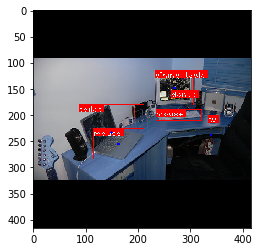

In [24]:
dataDir = './cocoapi/images/val2014'
annFile = './cocoapi/annotations/instances_val2014.json'

dataset = CocoDetection(root=dataDir,annFile=annFile)
# image, label = dataset[5]
# print (image.size())
# print (label)

dataset_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=1, 
                                           shuffle=True,
                                           collate_fn=dataset.collate_fn)

# When iteration starts, queue and thread start to load data from files.
data_iter = iter(dataset_loader)

# Mini-batch images and labels.
images, labels = data_iter.next() # labels: (index,category,x,y,w,h)
print(images.shape)
print(labels.shape)

b, c, h, w = images.shape
img = images.mul(255).byte()
img = img.cpu().numpy().squeeze(0).transpose((1, 2, 0))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

COCO_REVERSE_LABEL_MAP = { 1:  1,  2:  2,  3:  3,  4:  4,  5:  5,  6:  6,  7:  7,  8:  8,
                   9:  9, 10: 10, 11: 11, 12: 13, 13: 14, 14: 15, 15: 16, 16: 17,
                  17: 18, 18: 19, 19: 20, 20: 21, 21: 22, 22: 23, 23: 24, 24: 25,
                  25: 27, 26: 28, 27: 31, 28: 32, 29: 33, 30: 34, 31: 35, 32: 36,
                  33: 37, 34: 38, 35: 39, 36: 40, 37: 41, 38: 42, 39: 43, 40: 44,
                  41: 46, 42: 47, 43: 48, 44: 49, 45: 50, 46: 51, 47: 52, 48: 53,
                  49: 54, 50: 55, 51: 56, 52: 57, 53: 58, 54: 59, 55: 60, 56: 61,
                  57: 62, 58: 63, 59: 64, 60: 65, 61: 67, 62: 70, 63: 72, 64: 73,
                  65: 74, 66: 75, 67: 76, 68: 77, 69: 78, 70: 79, 71: 80, 72: 81,
                  73: 82, 74: 84, 75: 85, 76: 86, 77: 87, 78: 88, 79: 89, 80: 90}

bboxes = labels.cpu().numpy().squeeze()
for i in range(len(bboxes)):
    x1 = int(w * (bboxes[i][2]-bboxes[i][4]/2))  
    y1 = int(h * (bboxes[i][3]-bboxes[i][5]/2))
    x2 = int(w * (bboxes[i][2]+bboxes[i][4]/2))  
    y2 = int(h * (bboxes[i][3]+bboxes[i][5]/2))

    cv2.rectangle(img, (x1,y1), (x2,y2), (255, 0, 0), thickness=1)
    cv2.circle(img, (int(w*bboxes[i][2]),int(h*bboxes[i][3])), 1, (0,0,255), thickness=2)
    
    catId = COCO_REVERSE_LABEL_MAP[int(bboxes[i][1])-1]
    cat = coco.loadCats(catId)
    label = cat[0]['name']
    print(label)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    x3, y3 = x1+t_size[0]+3, y1+t_size[1]+4
    cv2.rectangle(img, (x1,y1), (x3,y3), (255, 0, 0), thickness=-1)
    cv2.putText(img, label, (x1, y1 + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);

plt.imshow(img)


#### 直接使用coco api加载图像并显示检测框

loading annotations into memory...
Done (t=1.40s)
creating index...
index created!
(640, 480, 3)


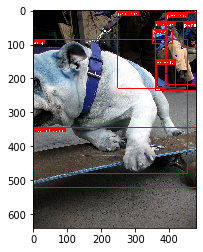

In [30]:
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt
import numpy as np

dataDir = "./cocoapi/images/val2017"
annFile = "./cocoapi/annotations/instances_val2017.json" 
coco = COCO(annFile)
catIds = coco.getCatIds(catNms=['person','dog','skateboard'])
imgIds = coco.getImgIds(catIds=catIds )
imgId = imgIds[np.random.randint(0,len(imgIds))]
img = coco.loadImgs(imgId)[0]
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)


img = cv2.imread('%s/%s'%(dataDir,img['file_name']))
print(img.shape)
for i in range(len(anns)):
    bbox = anns[i]['bbox']
    x1 = int(bbox[0])  
    y1 = int(bbox[1])
    x2 = int((bbox[0] + bbox[2]))  
    y2 = int((bbox[1] + bbox[3]))
    cv2.rectangle(img, (x1,y1), (x2,y2), (255, 0, 0), thickness=2)
    cv2.circle(img, (int((x1+x2)/2),int((y1+y2)/2)), 1, (0,0,255), thickness=2)
    
    catId = anns[i]['category_id']
    cat = coco.loadCats(catId)
    label = cat[0]['name']
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    x3, y3 = x1+t_size[0]+3, y1+t_size[1]+4
    cv2.rectangle(img, (x1,y1), (x3,y3), (255, 0, 0), thickness=-1)
    cv2.putText(img, label, (x1, y1 + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
plt.imshow(img)
# coco.showAnns(anns)

## COCO数据集目标检测评价指标

#### 检测结果格式
目标检测需要同时判断目标是否存在以及目标的位置，因此预测结果中必须包含“类别ID”以及bbox的坐标（一般用中心点坐标表示，也有可能用左上角坐标表示，COCO数据集用的是左上角坐标，本文将其转换成了中心点坐标）和大小（用宽度和高度表示）。同时，为了评估误判的风险，每一个预测框增加一个置信度分数（score）表示模型对该预测的信心。因此，预测结果具备以下结构：

In [ ]:
[{
    "image_id": int, 
    "category_id": int, 
    "bbox": [x,y,width,height], 
    "score": float,
}]

#### 什么是好的检测结果？
首先，一个好的检测结果必须能够正确预测目标的类别，类别错了一切白搭。
其次，检测的位置信息必须准确，也就是检测框必须尽可能地与目标贴合。“贴合度”往往采用IoU（交并比）来表示，交并比就是检测框与Ground Truth的重合面积（交集）与两者全部的面积（并集，不重复计算重合部分面积）的比值。


![图片来源见水印](images_/IoU.jpg "图片来源见水印")

*图片来源见水印*

#### COCO数据集中的目标检测评价指标
在COCO数据集中，主要采用以下12种指标评价目标检测模型的性能。

![](images_/Det_metrics.PNG "目标检测指标")

*注：[0.50:0.05:0.95] 表示从0.50到0.95以0.05为间隔的序列 (0.5, 0.55, 0.6, ..., 0.9, 0.95)*

*AP (averaged across all 10 IoU thresholds and all 80 categories)*

#### Average Precision (AP)
首先，在目标检测任务中，有些使用场景对位置的准确度要求不高，有些则要求精确定位。位置信息精确度通过设置不同IoU阈值实现，COCO数据集设定的阈值为 (0.5, 0.55, 0.6, ..., 0.9, 0.95)。给定某个阈值，如果检测框与Ground-Truth的Iou超过该阈值则视为检测成功，这样就可以计算出该IoU下模型的性能。

其次，需要考虑类别均衡的稳定，有些使用场景不同类别的目标检测的重要性不同（误检的影响大小不同），因此需要公平地评价检测模型在各个类别上的性能。先给定一个IoU阈值，然后对所有的检测结果和Ground-Truth按类别分类，并对每一个类别计算出一个准确率（AP），最后对所有类比的准确率取平均值（mAP），这就是这个模型在该IoU下的性能。

COCO数据集的AP和AR还需要将多个IoU下的性能表现做平均。


#### 传统 mAP 计算过程
给定IoU阈值，计算mAP。

1 定义所有的检测结果为dts，Ground-Truth为gts，遍历目标类别，选取每一类别的检测结果和Ground-Truth（_dts,_gts）

2 在该类别下，遍历图片，选取每一图片的检测结果和Ground-Truth（_dts_,_gts_）。

3 对该图品的检测结果（_dts_）依据置信度分数（score）排序

4 依序遍历_dts_中所有的dt，计算dt与_gts_内所有Ground-Truth的IoU，如果最大的IoU大于阈值，视为检测成功，算作TP（True Positive），并且最大IoU对应的gt被视为匹配成功。如果该dt与所有gt的IOU都没超过阈值，自然就是FP（False Positive）

5 同时，每当一个gt被检测成功后，都会从_gts_和_gts中“被取走”，以免后续的检测结果重复匹配

6 如果有多个检测结果都与同一个gt匹配，那么分数最高的那个会被算为TP，其余均为FP。所以所有在_dts中但不在TPs中的dt都属于FP

7 由于被匹配过的gt都会“被取走”，因此_gts中剩下的就是没有被匹配上的FN（False Negative） 

8 precision = TP / (TP + FP), recall = TP / (TP + FN)

9 在每一个类别下，对排序检测结果进行不同的“截断”（取前n个）可以计算出一组准确率和召回率，从而得到准确率_召回率曲线，计算出平均准确率AP(average precision)

10 对所有类别的AP取平均得到mAP

In [ ]:
# 个人理解的mAP计算过程伪代码，实际上还是直接使用MS COCO官方提供的api吧
def Evaluation(dts,gts,iou_thre):
    average_precisions = []
    for cat in enumerate(categories):
        # 对检测结果进行截断，只取前maxDet个检测结果，用于计算average precision
        precisions = []
        recalls = []
        for maxDet in enumerate(maxDets): #maxDets=[10,20,..,100]
            _dts = dts.get_dts_per_cat(cat) #获取某一类别的检测结果
            _gts = gts.get_gts_per_cat(cat) #获取某一类别的Ground_Truth
            TPs = []  #真阳性
            for img in enumerate(images):
                _dts_ = _dts.get_dts_per_cat(img) #获取某一图片的检测结果
                _gts_ = _gts.get_gts_per_cat(img) #获取某一图片的Ground_Truth
                _dts_.sort(reverse=True)
                _dts_ = _dts_.get_top_K(k=maxDet) #只取前maxDet个检测结果
                for dt in _dts_:
                    #get the max iou and the corresponding gt
                    max_iou = max([iou(dt,gt) for gt in _gts_])
                    max_iou_gt = argmax([iou(dt,gt) for gt in _gts_])
                    if max_iou >= iou_thre:
                        TPs.append(dt)
                        # never match one GT twice
                        _gts_.pop(max_iou_gt) 
                        _gts.pop(max_iou_gt)

            FPs = [dt for dt in _dts if not dt in TPs]
            FNs = _gts

            TP = len(TPs)
            FP = len(FPs)
            FN = len(FNs)
            precision = TP / (TP + FP)
            recall = TP / (TP + FN)

            precisions.append(precision)
            recalls.append(recall)
        # get average precision
        # plot a precision-recall curve, plotting precision p(r) as a function of recall r. 
        # Average precision computes the average value of p(r) over the interval from r=0 to r=1.
        curve = plot_precision_recall_curve(precisions,recalls)
        average_precision = sum(p(k)*r(k)) # k=1,...n
        average_precisions.append(average_precision)
    
    mAP = average_precisions.mean()

    return mAP


心烦，直接使用COCO官方提供的api吧。。。只要提供符合格式要求的结果文件就行

### 使用COCO API评估目标检测模型性能

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
annType = 'bbox'
prefix = 'instances'
print("Running demo for *%s* results."%(annType))

Running demo for *bbox* results.


#### 初始化COCO Ground-truth API

In [7]:
dataDir = './cocoapi'
dataType = 'val2014'
annFile = '%s/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt = COCO(annFile)

loading annotations into memory...
Done (t=8.03s)
creating index...
index created!


#### 初始化COCO检测结果API

In [9]:
resFile = '%s/results/%s_%s_fake%s100_results.json'%(dataDir,prefix,dataType,annType)
cocoDt = cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.34s)
creating index...
index created!


#### 获取图像ID

In [10]:
imgIds = sorted(cocoGt.getImgIds())
imgIds = imgIds[0:100]
imgId = imgIds[np.random.randint(100)]


#### 运行评估

In [11]:
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.45s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.697
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.501
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.387
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100